# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

import math
import statistics
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

Recall $\hat{y}=\hat{\beta_0} + \hat{\beta_1}x_1 + ... + \hat{\beta_n}x_n + \epsilon$.
Now, imagine we wanted to regress data that had a binary response. What would that look like?

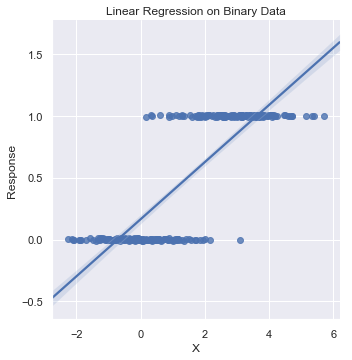

In [2]:
#Generate Data
data = pd.DataFrame({'X':np.random.randn(150).tolist(),'Response':np.full(150,0).tolist()})
ones = np.random.randn(150)+3
data = data.append(pd.DataFrame({'X':ones.tolist(),'Response':np.full(150,1).tolist()}))

#Plot Regression
sns.lmplot(x='X',y='Response',data=data,y_jitter=.01).set(title='Linear Regression on Binary Data')

Note that this could predict a value outside of [0,1] for a binary response! You could bound the function to between 1 and zero, but you are liable to misclassify anything that is towards the middle.

Logistic regression is the solution to this problem. This special type of regression model was created to answer the question of what is the probability of a boolean response returning 0/1 based on a set of predictors. Let's derive the formula.

Suppose $p$ is a probability. Then $\frac{p}{1-p}$ is the odds of the event. Thus we can then define the log of the odds (the log-odds) as $log(\frac{p}{1-p})$.

The graph of $log(\frac{p}{1-p})$ is:

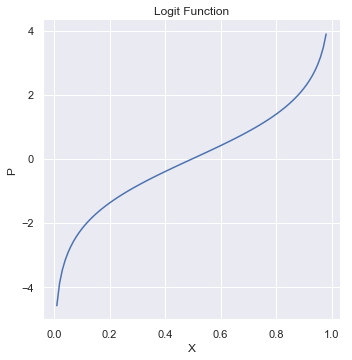

In [3]:
X = np.arange(.01, .99, .01).tolist()
P = list(map(lambda x: math.log(x/(1-x)), X))
sns.relplot(x='X',y='P',data=pd.DataFrame({'X':X,'P':P}),kind='line').set(title='Logit Function')

We can see the function $f(p)=log(\frac{p}{1-p})$ maps $(-\infty,\infty)$ to $(-1,1)$ for all $p$.
Now, since we have this smoothly bounded, we would like to establish a set of linear predictors for the regression.

Let's define $p$ as the probability for an event and $q$ the probability against ($q=1-p$). This makes $\frac{p}{q}$ the odds.

Since we would like to create a linear model out of the log-odds, let's declare our linearly combined coefficients and predictors:

$$E[y|x_1...x_n]=logit(p)=f(\frac{p}{q})=log(\frac{p}{1-p})=\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n$$

Note specifically that this implies:

$$log(odds_{For})=log(\frac{p}{1-p})=\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n$$

Now, if we take the base of the logarithm to be $e$ and exponentiate we find:

$$odds_{For}=e^{log(odds_{For})}=e^{f(\frac{p}{q})} = e^{log(\frac{p}{1-p})}=\frac{p}{1-p}=e^{\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n}$$

$p$ is a probability so the following property exists:
$$p=\frac{odds_{For}}{1+odds_{For}}=\frac{e^{\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n}}{e^{\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n}+1}=\frac{1}{1+e^{-(\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n)}}$$

Or rather the logistic (sigmoid) function that returns a probability:

$$\sigma(T)=\frac{1}{1+e^{-T}}$$

$$T=\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n,\ n\ predictors$$

Thus the probability of success will actually be: 
$$p=\frac{1}{1+e^{-\ (\hat{\beta_0}+\hat{\beta_1}x_1+\ ...\ +\hat{\beta_n}x_n)}},\ n\ predictors$$ 

This implies that for a single predictor, we have the equation:
$$p(x)=\frac{1}{1+e^{\ -(\hat{\beta_0}+\hat{\beta_1}x)}}$$



Let's graph: $f(x)=\frac{1}{1+e^{-nx}}, n=[0,.2,.4,\ ...\ ,2]$

[Text(0.5,1,'Logistic Regression Adjusted')]

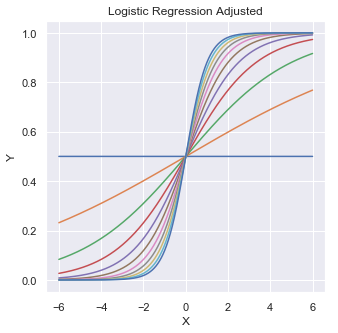

In [4]:
#Prep Layered Plot
fig, ax = plt.subplots(figsize=(5,5))

#Graph
X = np.arange(-6, 6, .01).tolist()
for i in range(11):
    Y = list(map(lambda x: 1/(1+math.e**(x*i/5*-1)), X))
    a = sns.lineplot(x='X',y='Y',data=pd.DataFrame({'X':X,'Y':Y}),ax=ax)
a.set(title='Logistic Regression Adjusted')

It can also be easily used to estimate membership in a group

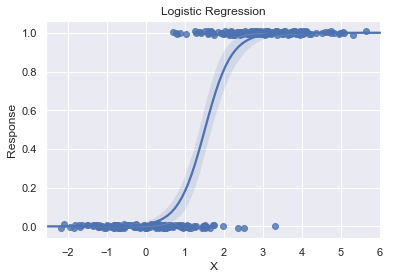

In [5]:
#Generate Data
data = pd.DataFrame({'X':np.random.randn(150).tolist(),'Response':np.full(150,0).tolist()})
ones = np.random.randn(150)+3
data = data.append(pd.DataFrame({'X':ones.tolist(),'Response':np.full(150,1).tolist()}))

#Plot Regression
ax = sns.regplot(x='X',y='Response',data=data,y_jitter=.01,logistic=True).set(title='Logistic Regression')

So how is the optimal solution found?

A drawback to this sort of analysis is you lose the ability to conduct an LSE to find your estimated betas. As an alternative, what is used is a Mean log-Likelihood Estimation (MLE). Using the above equation we find our estimated $\hat{y}$. I will spare you the calculus and derivation, but we then find a cost function of:

$$\ h_T(x)=\frac{1}{1+e^{-T}},\ T=\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n,\ n\ predictors$$

$$ Error(T,y)=   \left\{
\begin{array}{ll}
      -log(h_T(x)) & y = 1 \\
      -log(1-h_T(x)) & y = 0 \\
\end{array} 
\right.$$

$$Error(T,y)=-ylog(h_T(x))-(y-1)log(1-h_T(x))$$

$$MLE = Cost(T)=-\frac{1}{m}\sum_{i=1}^m[y_ilog(h_T(x_i))+(1-y_i)log(1-h_T(x_i))],\ m\ Observations$$

To try to draw at least some form of intuition from this cost function,
we can think of this as a way of taking the sigmoid (logistic) function and using solely
convex functions to assign a cost so that a descent engine can find a global minimum.
Let's visualize what this logging does.

[Text(0.5,1,'Cost for Y=1')]

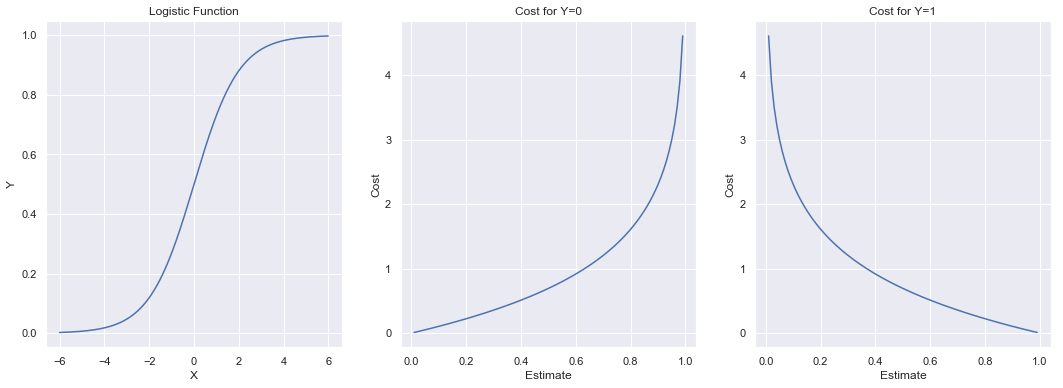

In [6]:
fig, axs = plt.subplots(ncols=3,figsize=(18,6))

#Sigmoid
X = np.arange(-6, 6, .01).tolist()
Y = list(map(lambda x: 1/(1+math.e**(x*-1)), X)) #f(x) = 1/(1+e**(-x))
sns.lineplot(x='X',y='Y',data=pd.DataFrame({'X':X,'Y':Y}),ax=axs[0])
axs[0].set(title='Logistic Function')

#Zero Cost
X = np.arange(0.01, 1, .01).tolist()
Y = list(map(lambda x: -math.log(1-x), X)) #f(x) = 1/(1+e**(-x))
sns.lineplot(x='Estimate',y='Cost',data=pd.DataFrame({'Estimate':X,'Cost':Y}),ax=axs[1])
axs[1].set(title='Cost for Y=0')

#One Cost
X = np.arange(0.01, 1, .01).tolist()
Y = list(map(lambda x: -math.log(x), X)) #f(x) = 1/(1+e**(-x))
sns.lineplot(x='Estimate',y='Cost',data=pd.DataFrame({'Estimate':X,'Cost':Y}),ax=axs[2])
axs[2].set(title='Cost for Y=1')

As you can see, it makes some sense that the further you are from being accurate, the higher your punishment should be. By using these smooth, convex logarithms, we can allow the computer a guarantee that they will find the global minimum of the punishment function. You can see this implemented below.

In [7]:
def predict(x,beta1,beta0):
    return min(0.99999999999999,1/(1+math.e**(-1*(beta0+beta1*x))))

def error(x,beta1,beta0,y):
    yhat = predict(x,beta1,beta0)
    return y*math.log(yhat)+(1-y)*math.log(1-yhat)

def getCost(beta1,beta0, X, Y):
    return -1 * statistics.mean(list(map(lambda x, y: error(x,beta1,beta0,y), X, Y)))

def getHMData(beta1,beta0,X,Y,step=0.1,):
    b1Dist = beta1[1]-beta1[0]
    b1Steps = int(b1Dist/step)
    
    b0Dist = beta0[1]-beta0[0]
    b0Steps = int(b0Dist/step)
    
    data = []
    for i in range(b1Steps):
        row = []
        for j in range(b0Steps):
            row.append(getCost(beta1=beta1[0]+step*i,beta0=beta0[0]+step*j,X=X,Y=Y))
        data.append(row)
    
    return pd.DataFrame(data)

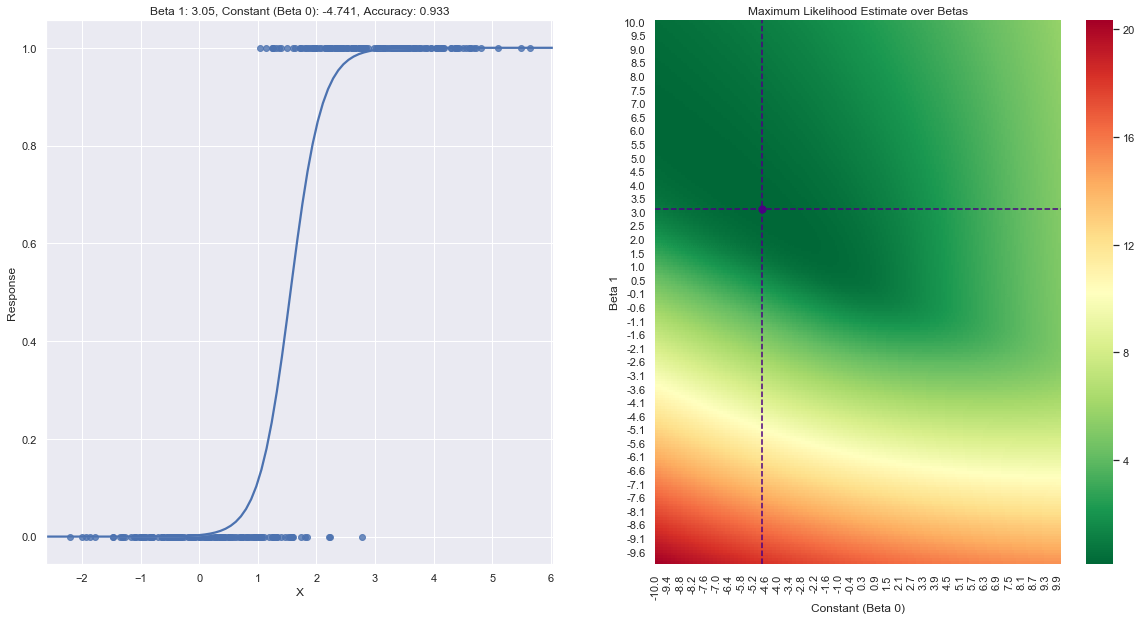

In [8]:
#Set Limits
increment = 0.1
beta1s = [-10,10]
numb1s = (beta1s[1]-beta1s[0])/increment
beta0s = [-10,10]
numb0s = (beta0s[1]-beta0s[0])/increment

#Generate Data
data = pd.DataFrame({'X':np.random.randn(150).tolist(),'Response':np.full(150,0).tolist()})
ones = np.random.randn(150)+3
data = data.append(pd.DataFrame({'X':ones.tolist(),'Response':np.full(150,1).tolist()}))
hmdata = getHMData(beta1=beta1s,beta0=beta0s,X=data['X'],Y=data['Response'],step=increment)

#Format Labels
hmdata = hmdata.set_index(np.linspace(beta1s[0],beta1s[1],int(numb1s)).round(1))
hmdata.columns = np.linspace(beta0s[0],beta0s[1],int(numb0s)).round(1)

#Heat Map of MSE
fig, axs = plt.subplots(ncols=2,figsize=(20,10))
sns.heatmap(hmdata.iloc[::-1,:],cmap="RdYlGn_r",ax = axs[1]).set(title='Maximum Likelihood Estimate over Betas')
axs[1].set(xlabel='Constant (Beta 0)',ylabel='Beta 1')

#Regression Plot
sns.regplot(x='X',y='Response',data=pd.DataFrame({'X':data['X'],'Response':data['Response']}), logistic=True,
            ci=False, ax = axs[0])
logreg = LogisticRegression(solver='lbfgs',penalty='l2').fit(data['X'].values.reshape(-1, 1),data['Response'])
title = ('Beta 1: '+str(round(logreg.coef_[0,0],3))+', Constant (Beta 0): '+
         str(round(logreg.intercept_[0],3))+', Accuracy: '+
         str(round(logreg.score(X=data['X'].values.reshape(-1, 1),y=data['Response']),3)))
axs[0].set_title(title)

#Plot Over Heatmap
axs[1].hlines([logreg.coef_[0,0]*-10+100], *axs[1].get_xlim(),linestyles='dashed',colors='indigo')
axs[1].vlines([logreg.intercept_[0]*10+100], *axs[1].get_ylim(),linestyles='dashed',colors='indigo')
axs[1].scatter(logreg.intercept_[0]*10+100,logreg.coef_[0,0]*-10+100,zorder=10,c='indigo',s=50)

Note how the gradations in the heatmap appear perfectly convex, where should you imagine a marble rolling going towards the lowest point, overshooting and repeating the process, it will eventually settle at the bottom. This is conceptually identical to the way gradient descent works in all contexts. To aid in understanding, imagine the heatmap as a representation of a vector field where each point has a vector in the direction of its neighbor with the lowest MLE value and magnitude equal to the difference in MLEs. The marble will follow exactly the path laid out from these arrows starting from an initial guess ending at the lowest MLE where there will be a null vector (i.e. nowhere else to roll). This can then be thought of in the third dimension (two-predictor model) as free space with a ball in zero-gravity flowing via the vector field towards the point in space with lowest MLE, and so on into infinite dimensional space.

## Multiple Predictor Models

It is important to note that this can expand to infinitely many dimensions, all working together to predict a single binary response variable. In these cases, we can imagine the logistic regression function as a linear model where we are simply increasing the number of linearly combined betas and features to give us a final log-odds and thus probability of membership in a group. Let's observe the following example.

Let's create two different groups we want to predict using two separate predictors. In other words, we have a binary response predicted using two numeric features.

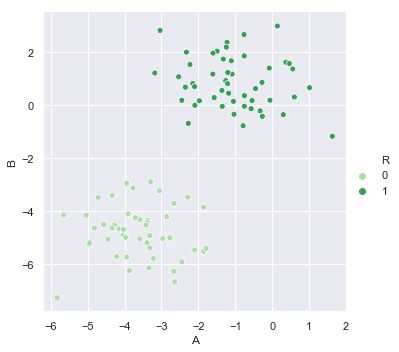

In [9]:
#Data Generation
AB, response = datasets.make_blobs(n_samples=100, centers=2, n_features=2)

data = {'A':[],'B':[],'R':[]}
for i in AB:
    data['A'].append(i[0])
    data['B'].append(i[1])
    data['R'].append(response[len(data['A'])-1])
data = pd.DataFrame(data)

sns.relplot(data=data, x='A',y='B', hue='R', palette='Greens')

We would like to create a line that would allow us to separate these two groups. In our case, it seems a linear separation would work well, so logistic regression is a reasonable choice. Let's predict.

In [10]:
logreg = LogisticRegression(solver='liblinear',penalty='l1').fit(data[['A','B']],data['R'])

And lets see how this fits the data

Text(0,0.5,'B')

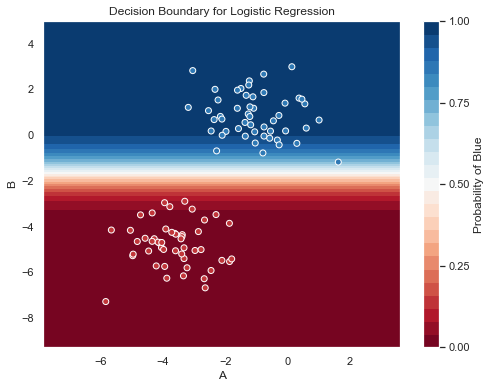

In [11]:
xx, yy = np.mgrid[min(data['A'])-2:max(data['A'])+2:.01, min(data['B'])-2:max(data['B'])+2:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = logreg.predict_proba(grid)[:, 1].reshape(xx.shape)

fig, ax = plt.subplots(figsize=(8, 6))
c = plt.contourf(xx, yy, probs, 25, cmap='RdBu')
leg = fig.colorbar(c)
leg.set_label("Probability of Blue")
leg.set_ticks([0, .25, .50, .75, 1])
plt.scatter(data['A'],data['B'],c=data['R'],cmap='RdBu',vmin=-.2, vmax=1.2,edgecolors='white')
plt.title('Decision Boundary for Logistic Regression')
plt.xlabel('A')
plt.ylabel('B')

Notice that what comes out of all of this nonlinear craziness is a smooth linear line with gradations on either side. This may seem odd at first, but recall that the whole point of this was to create a linear model. When we learn on our data to find our betas, they have the form $log(\frac{p}{1-p})=\beta_0 + \beta_1 x_1 +\ ...\ +\beta_n x_n$.

We are not, however, completely in the dark as it comes to fine tuning this sort of problem. We would like to have some control over how much fitting the model does, in order to avoid overfitting. This is done primarily though the lambda, the coefficient of a function of the betas.

## The lambda complexity-cost adjustment

As we add more and more predictors to the model, we must make an effort to avoid overfitting. In cases where we have hundreds to thousands of potential features this is even more important. The way that this is done in logistic regression is through what is called regularization where we penalize our model on some function of the set of coefficients on the predictors. Generally, this is either done on the $l_1=\sum_{i=1}^n|w_i|$ or $l_2=\sum_{i=1}^nw_i^2$. Because this is such an important thing to consider, it is generally built into statistical packages (including SciKitLearn). Called $\lambda$ this is the multiple put onto the aggregation of the weights. SKLearn, which is what this analysis is using considers the inverse, i.e. $\frac{1}{\lambda}=c$. This means that small values of $c$ create larger regulation coefficients.

This is probably best illustrated through an example.

In [12]:
data.loc[data.loc[data['R']==0,'R'].index[0],'R']=1 #Change a random red datapoint

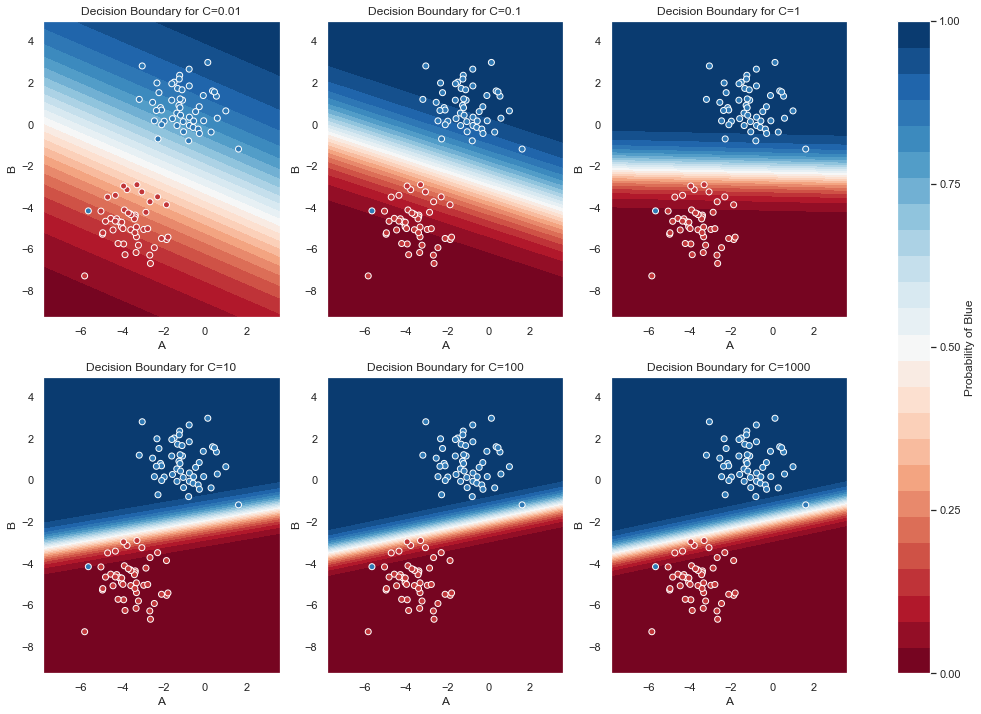

In [13]:
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(18,12))
r=0
cl=0

for i in [0.01,0.1,1,10,100,1000]:
    logreg = LogisticRegression(solver='lbfgs',C=(i)).fit(data[['A','B']],data['R'])
    probs = logreg.predict_proba(grid)[:, 1].reshape(xx.shape)
    
    axs[r,cl].contourf(xx, yy, probs, 25, cmap='RdBu')
    axs[r,cl].scatter(data['A'],data['B'],c=data['R'],cmap='RdBu',vmin=-.2, vmax=1.2,edgecolors='white')
    axs[r,cl].set_title('Decision Boundary for C='+str(i))
    axs[r,cl].set_xlabel('A')
    axs[r,cl].set_ylabel('B')
    cl+=1
    if cl>0 and cl%3==0:
        r+=1
        cl=0

leg = fig.colorbar(c, ax=axs.ravel().tolist())
leg.set_label("Probability of Blue")
leg.set_ticks([0, .25, .50, .75, 1])

So, we can now define our cost function as:

$$\ h_\theta(T)=\frac{1}{1+e^{-T}},\ T=\beta_0+\beta_1 x_1 +\ ...\ + \beta_n x_n$$

$$MLE = Cost(T)=-\frac{1}{m}\sum_{i=1}^m[y_ilog(h_T(x_i))+(1-y_i)log(1-h_T(x_i))]+\lambda\sum_{j=1}^n(w_j^2)$$

$$\ m\ Observations,\ n\ Predictors,\ l_2\ Regulation,\ w_j\ Weights$$

## Scaling

Now that we have a finalized cost function, we need to acknowledge that it is dependent on the weights of our coefficients. As such, the scale of the coefficients now matters. For example, if we are to apply some sort of coefficient on very small numbers of data, we will need a relatively large weight compared to if the input is a large number. As such, we would like to standardize our data to be of an equal mean and standard deviation. This is very simple through SKLearn.

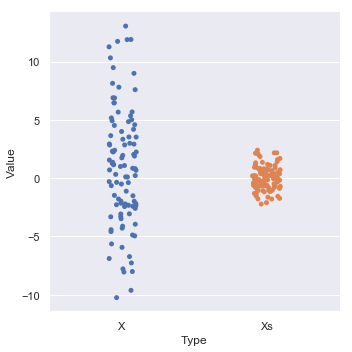

In [14]:
ss = StandardScaler()

X = np.random.randn(100)*5
Y = np.random.randint(0,2,size=100)
Xs = ss.fit_transform(np.array(X).reshape(-1,1))

data = pd.DataFrame({'Type':'X','Value':X})
data = data.append(pd.DataFrame({'Type':'Xs','Value':Xs.flatten().tolist()}))

sns.catplot(x='Type',y='Value',data=data)

In cases where you have outliers that you may want to mostly ignore in the standardization process, you can use a robust scaler that instead uses interquartile ranges. Let's see.

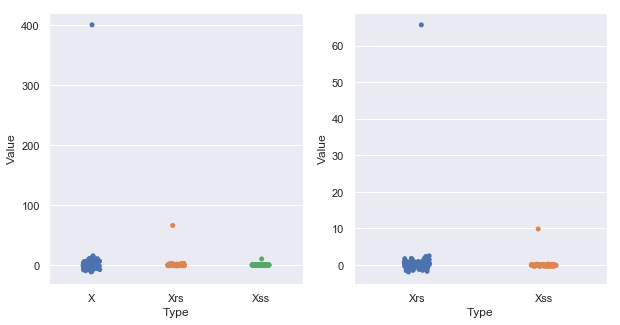

In [15]:
rs = RobustScaler()
ss = StandardScaler()

X = np.random.randn(100)*5
X[0] = 400
Y = np.random.randint(0,2,size=100)
Xrs = rs.fit_transform(np.array(X).reshape(-1,1))
Xss = ss.fit_transform(np.array(X).reshape(-1,1))

data = pd.DataFrame({'Type':'X','Value':X})
data = data.append(pd.DataFrame({'Type':'Xrs','Value':Xrs.flatten().tolist()}))
data = data.append(pd.DataFrame({'Type':'Xss','Value':Xss.flatten().tolist()}))

fig, axs = plt.subplots(ncols=2,figsize=(10,5))
sns.stripplot(x='Type',y='Value',data=data,ax=axs[0])
sns.stripplot(x='Type',y='Value',data=data[data['Type'] != 'X'])

## Splitting Training and Testing

When we conduct analysis on large amounts of data, it is best practice to place some of this off to the side in order to avoid overfitting. By overfitting, we mean going beyond just finding the general trends in data and modeling idiosyncracies of the points that are in your sample. This is done very simply in python using SKLearn.

In [16]:
#Generate Data
X = np.random.randn(100)
Y = np.random.randint(0,2,size=100)

#Four Pieces
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print('Size of X_train:',len(X_train))
print('Size of X_test:',len(X_test))
print('Size of y_train:',len(y_train))
print('Size of y_test:',len(y_test))

Size of X_train: 80
Size of X_test: 20
Size of y_train: 80
Size of y_test: 20


Importantly, this will just segment the data randomly. If we want to have subsets with the same sort of distribution as the original, we must ask for a stratified sample.

In [17]:
#Potential Reptition of Y
sss = StratifiedShuffleSplit(n_splits=3)
sss.get_n_splits(X, Y)
a,b,c = sss.split(X,Y)
print('Train 1 (Length '+str(len(a[0]))+'):',a[0])
print('Test 1 (Length '+str(len(a[1]))+'):',a[1])

Train 1 (Length 90): [26 70 13 48 43 68 21 58 97 87 57 30 42 33 25 36 61 10 14 22 80 40 62 71
 76 64 45 94 66  7 78 19 89 20 50 44 41  2  9 73 54 51 69 34 47 84 52 29
 55 53 75 27 95 59  6  1 46 72 23 99 63 91 17 82  3 92 65 24 31 16 93 98
 32 83 81 15 18 11  5 60 90 86 67  8 35 74 96 39 37  0]
Test 1 (Length 10): [ 4 79 49 28 77 38 56 12 88 85]


In [18]:
#No Repetition of Y
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, Y)
a,b,c = skf.split(X,Y)
print('Train 1 (Length '+str(len(a[0]))+'):',a[0])
print('Test 1 (Length '+str(len(a[1]))+'):',a[1])

Train 1 (Length 66): [32 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Test 1 (Length 34): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 33 34]


## Cross Validation and Holdout

When you take away data for training and testing, there can be some leakage of information into the model through the testing period. In other words, by using the same data as a testing set, it is possible that there will be some impact on the model based on the repeated testing. As such, by splitting in $n$ groups and training on $n-1$ groups, testing on the other, you can find an average performance that is a more honest and accurate reflection of how the model will perform in reality.

It is very easy to execute this type of process using SKLearn.

In [19]:
#Create Data
X = np.random.randn(100)
Y = np.random.randint(0,2,size=100)

#Create Model
logreg = LogisticRegression(solver='lbfgs').fit(X.reshape(-1,1),Y)
scores = cross_val_score(logreg, X.reshape(-1,1), Y, cv=5)
print('Scores:',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores: [0.38095238 0.65       0.55       0.3        0.47368421]
Accuracy: 0.47 (+/- 0.25)


You can also work to solve this problem by creating what is known as a holdout set of data. This is where you take away a subset of the data for the sole purpose of testing the overall performance of the model, as opposed to the testing data which you use as a tool to check how you are performing within the training.

In [20]:
#Create Data
X = np.random.randn(100)
Y = np.random.randint(0,2,size=100)

#Four Pieces
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#Create Model
logreg = LogisticRegression(solver='lbfgs').fit(X.reshape(-1,1),Y)
scores = cross_val_score(logreg, X_train.reshape(-1,1), y_train, cv=5)
test = logreg.score(X_test.reshape(-1,1),y_test)
print('Scores:',scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
print('Test Accuracy:',test)

Scores: [0.58823529 0.5625     0.5625     0.5625     0.53333333]
Accuracy: 0.56 (+/- 0.03)
Test Accuracy: 0.5


## Confusion Matrix

Let's now take a moment to return to evaluating how successful our models are. Classification and regression clearly require different methods. When it comes to a boolean response, using a confusion matrix is a standard way to go about establishing this kind of success.

The matrix is as follows:

|True Positive | False Positive|

|False Negative | True Negative|

In [21]:
#Data Generation
X, y = datasets.make_classification(n_samples=300,n_features=3,n_redundant=0)

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Predictions
logreg = LogisticRegression(solver='lbfgs').fit(X_train,y_train)

#Create Matrix
print(metrics.confusion_matrix(y_test,logreg.predict(X_test)))

[[23  5]
 [ 2 30]]


## How a Real Model Would Work

In [22]:
#Generate Data
data = pd.DataFrame({'X':np.random.randn(1000).tolist(),'Response':np.full(1000,0).tolist()})
ones = np.random.randn(1000)+3
data = data.append(pd.DataFrame({'X':ones.tolist(),'Response':np.full(1000,1).tolist()}))

#Splits
X_train, X_test, y_train, y_test = train_test_split(data['X'], data['Response'], test_size=0.25)
sss = StratifiedShuffleSplit(n_splits=5)
skf = StratifiedKFold(n_splits=5)

#Manual Calculation of Stratified Shuffle Split
scores = []
for train_index, test_index in sss.split(X_train,y_train):
    xtrn,xtst = data['X'].iloc[train_index],data['X'].iloc[test_index]
    ytrn,ytst = data['Response'].iloc[train_index],data['Response'].iloc[test_index]
    
    logreg = LogisticRegression(solver='lbfgs').fit(np.array(xtrn).reshape(-1,1),ytrn)
    score = logreg.score(np.array(xtst).reshape(-1,1),ytst)
    print('Stratified Shuffle Split Score: %0.2f'%score)
    scores.append(score)

#Automatic Stratified K-Fold Calculation
cvscores = cross_val_score(logreg, np.array(X_train).reshape(-1,1), y_train, cv=skf.split(X_train,y_train))

#Test Accuracy
test = logreg.score(np.array(X_test).reshape(-1,1),y_test)

print('\nCross-Validation (Stratfied Shuffle Split) Accuracy: %0.2f (+/- %0.2f)' % (sum(scores)/len(scores),
                                                                             np.std(scores) * 2))
print('Cross-Validation (Stratified K-Fold) Accuracy: %0.2f (+/- %0.2f)' % (cvscores.mean(), cvscores.std() * 2))

print('\nTest Accuracy:',test)

Stratified Shuffle Split Score: 0.92
Stratified Shuffle Split Score: 0.94
Stratified Shuffle Split Score: 0.92
Stratified Shuffle Split Score: 0.93
Stratified Shuffle Split Score: 0.92

Cross-Validation (Stratfied Shuffle Split) Accuracy: 0.93 (+/- 0.02)
Cross-Validation (Stratified K-Fold) Accuracy: 0.93 (+/- 0.02)

Test Accuracy: 0.916


We can also modulate C in order to get the optimal tuning of the model.

In [23]:
#Generate Data
data = pd.DataFrame({'X':np.random.randn(1000).tolist(),'Response':np.full(1000,0).tolist()})
ones = np.random.randn(1000)+1
data = data.append(pd.DataFrame({'X':ones.tolist(),'Response':np.full(1000,1).tolist()}))

#Splits
X_train, X_test, y_train, y_test = train_test_split(data['X'], data['Response'], test_size=0.25)
sss = StratifiedShuffleSplit(n_splits=5)
skf = StratifiedKFold(n_splits=5)

#Calculating crossval for Cs
cvscores = []
cvmeans = []
Cs = [.00001,.0001,.001,.01,.01,.1,1,10]
for i in range(len(Cs)):
    logreg = LogisticRegression(solver='lbfgs',C=Cs[i]).fit(np.array(xtrn).reshape(-1,1),ytrn)
    cvscores = cross_val_score(logreg, np.array(X_train).reshape(-1,1), y_train,cv=skf.split(X_train,y_train))
    cvmeans.append(sum(cvscores)/len(cvscores))
    print('For C =',Cs[i],'Crossval Mean = %.03f'% cvmeans[i])

For C = 1e-05 Crossval Mean = 0.503
For C = 0.0001 Crossval Mean = 0.678
For C = 0.001 Crossval Mean = 0.691
For C = 0.01 Crossval Mean = 0.697
For C = 0.01 Crossval Mean = 0.697
For C = 0.1 Crossval Mean = 0.698
For C = 1 Crossval Mean = 0.698
For C = 10 Crossval Mean = 0.698


Let's see how to look at the individual predictors.

In [24]:
logreg = sm.Logit(y_train,X_train)
logreg.fit().summary()

Optimization terminated successfully.
         Current function value: 0.600515
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1499
Method:                           MLE   Df Model:                            0
Date:                Wed, 13 Mar 2019   Pseudo R-squ.:                  0.1336
Time:                        18:17:49   Log-Likelihood:                -900.77
converged:                       True   LL-Null:                       -1039.7
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.8095      0.055     14.659      0.000       0.701       0.918
==============================================================================
"""

Just like before, features can be chosen based on their P-value (but we will cover feature elimination soon).

## The ROC Curve

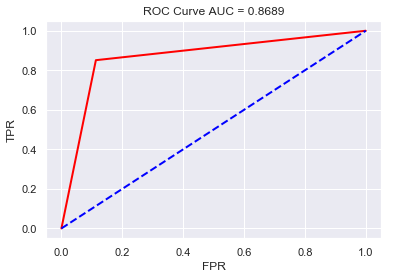

In [25]:
## Let's look at how we can evaluate success
Xs, y = datasets.make_classification(n_samples=500,n_features=3,n_redundant=0)

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

#Predictions
logreg = LogisticRegression(solver='lbfgs').fit(X_train,y_train)
aucscore = metrics.roc_auc_score(logreg.predict(X_test),y_test)

##Computing false and true positive rates
fpr, tpr,_= metrics.roc_curve(logreg.predict(X_test),y_test,drop_intermediate=False)

##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve AUC = '+str(aucscore.round(4)))
plt.show()

## Some Practice

Please **as teams** look at this data and create a logistic regression model. Following this, please evaluate which of the predictors are useful in modeling y. There should be 3. Once this is done, select an appropriate C by a method of your choosing. Please holdout 20% of your data and do a 5-fold cross validation on the rest. Then, give the estimate of the holdout behavior. Please then create a ROC curve for your model using the methodology laid out above as well a confusion matrix.

Evaluate your success

In [26]:
Xs, y = datasets.make_classification(n_samples=500,n_features=5,n_redundant=0,n_informative=3)